In [16]:
import argparse
import json
import os
import pandas as pd
from pprint import pprint
import numpy as np
from vega import VegaLite
from ipywidgets import widgets, interact, interactive, fixed, interact_manual
from IPython.display import clear_output

# default directories
OUTPUT_DIR = os.path.join(".")
MAX_TIME = 600

def parse_log_content(exp_id, data_id, lines):
    """parse a log file"""
    status = {
        "exp_id": exp_id,
        "data_id": data_id,
        "num_candidates": [],
        "table_prog": None,
        "vis_spec": None,
        "time": MAX_TIME
    }
    for i, l in enumerate(lines):
        if l.startswith("# candidates before getting the correct solution: "):
            status["num_candidates"].append(int(l.split(":")[-1].strip()) + 1)
        if l.startswith("# time used (s): "):
            status["time"] = float(l.split(":")[-1].strip())
        if l.startswith("# table_prog:") and len(lines) > i + 1:
            #status["table_prog"] = lines[i + 1]
            pass
        if l.startswith("# vis_spec:") and len(lines) > i + 1:
            #status["vis_spec"] = lines[i + 1]
            pass
    status["solved"] = False if status["time"] >= MAX_TIME else True
    status["num_explored"] = sum(status["num_candidates"])
    status.pop("num_candidates")
    return status

def read_log_result_list(log_dir_list, titles=None):
    all_result = []
    for i, log_dir in enumerate(log_dir_list):
        for fname in os.listdir(log_dir):
            if not fname.endswith(".log"): continue
            fpath = os.path.join(log_dir, fname)
            title = log_dir if titles is None else titles[i]
            with open(fpath) as f:
                status = parse_log_content(title, fname.split(".")[0], f.readlines())
                all_result.append(status)
    all_result.sort(key=lambda x:x["time"])
    return all_result

def plot_solving_time(log_dir_list, titiles=None):
    
    all_result = read_log_result_list(log_dir_list, titiles)
    
    plot_data = []
    for i in np.linspace(0.01, MAX_TIME, 1000):
        cnt = {}
        for r in all_result:
            if r["exp_id"] not in cnt:
                cnt[r["exp_id"]] = 0
            if r["solved"] and r["time"] > 0 and r["time"] < i:
                cnt[r["exp_id"]] += 1
        for exp_id in cnt:
            plot_data.append({"time": i, "cnt": cnt[exp_id], "exp_id": exp_id })
    
    df = pd.DataFrame.from_dict(all_result)
    chart = {
        "width": 800,
        "autosize": { "type": "fit", "contains": "padding"},
        "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
        "mark": {"type": "bar"},
        "encoding": {
            "y": {"field": "time", "type": "quantitative"},
            "x": { "field": "data_id", "type": "nominal", "sort": None},
            "color": {"field": "solved", "type": "nominal"},
            "row": {"field": "exp_id", "type": "nominal"}
        }
    }
    VegaLite(chart, df).display()
    
    cdf_data = pd.DataFrame.from_dict(plot_data)
    chart2 = {
        "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
        "mark": {"type": "line"},
        "encoding": {
            "y": {"field": "cnt", "type": "quantitative", "title": "# of solved benchmarks"},
            "x": { "field": "time", "type": "quantitative", "title": "Time (s)"},# "scale": {"type": "log", "base": 10}},
            "color": {"field": "exp_id", "type": "nominal"},
            "order": {"field": "time"}
        }
    }
    VegaLite(chart2, cdf_data).display()

    
def plot_num_candidates(log_dir_list, titles):
    all_result = read_log_result_list(log_dir_list, titles)
    df = pd.DataFrame.from_dict(all_result)
    df = df[df["solved"] == True]
    
    for t in titles:
        cases_solved_within_top_5 = []
        print("---{}".format(t))
        dft = df[df["exp_id"]==t]
        print("# cases solved within top 5:")
        print(list(dft[dft["num_explored"] <= 5]["data_id"]))
        print("solved within top 1: {}".format(len(dft[dft["num_explored"] <= 1])))
        print("solved within top 3: {}".format(len(dft[dft["num_explored"] <= 3])))
        print("solved within top 5: {}".format(len(dft[dft["num_explored"] <= 5])))
        print("total: {}".format(len(dft)))
    chart = {
        "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
        "mark": {"type": "bar"},
        "encoding": {
            "x": {"field": "num_explored", "type": "quantitative"},
            "y": {"aggregate": "count", "type": "quantitative"}, # , "scale": {"type": "log"}
            "column": {"field": "exp_id", "type": "nominal"}
        }
    }
    VegaLite(chart, df).display()
    
log_folders = ["select a folder"] + [dname for dname in os.listdir(OUTPUT_DIR) 
               if os.path.isdir(os.path.join(OUTPUT_DIR, dname)) and dname.startswith("exp")]

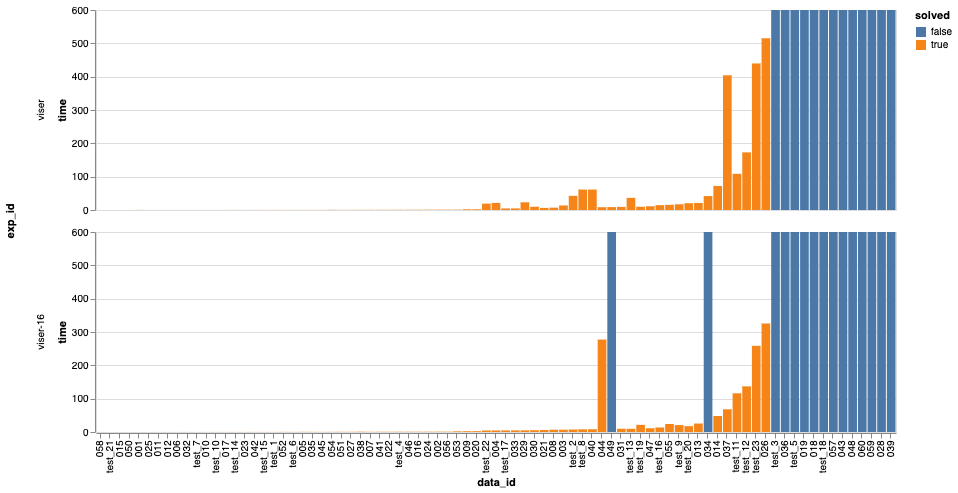

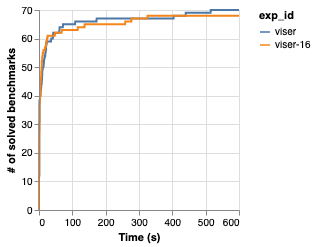

In [2]:
plot_solving_time(["exp_falx_4", "exp_falx_16"], ["viser", "viser-16"])

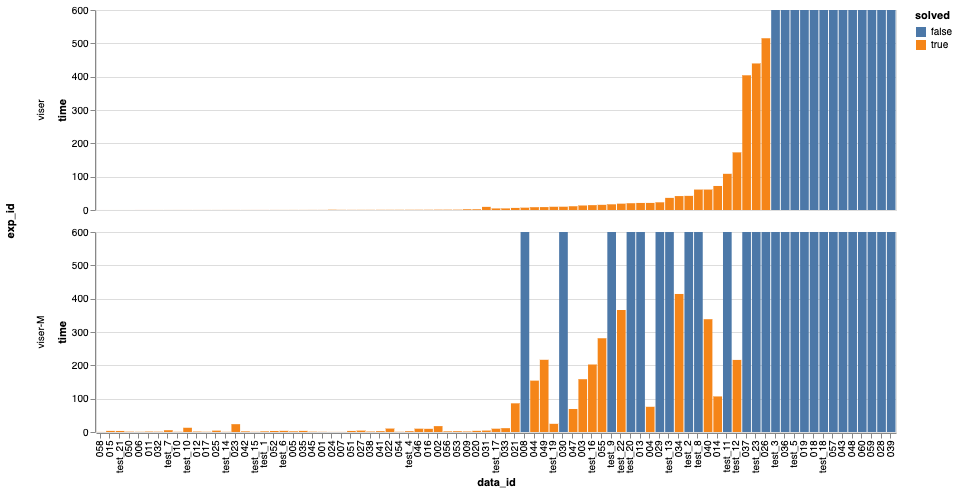

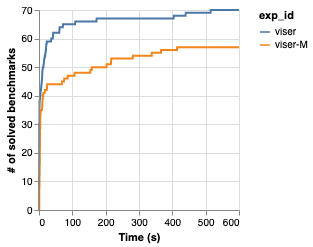

In [3]:
plot_solving_time(["exp_falx_4", "exp_morpheus_4"], ["viser", "viser-M"])

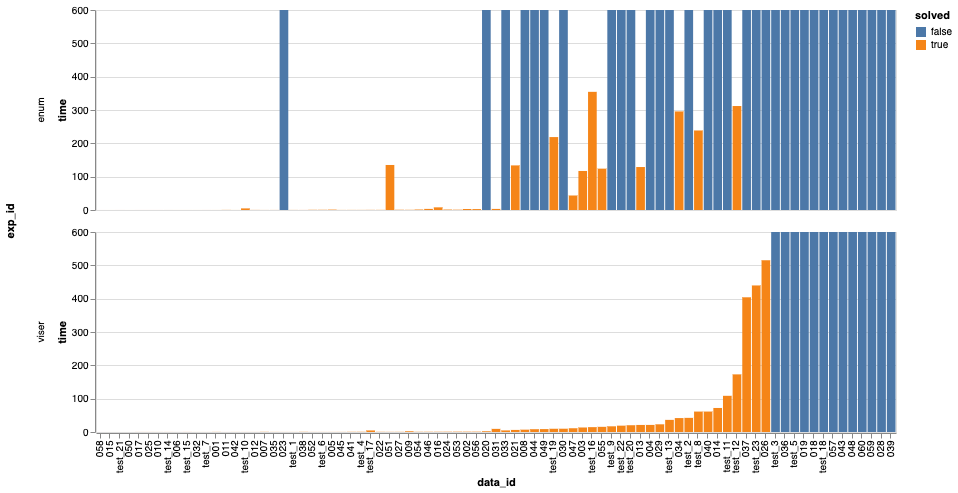

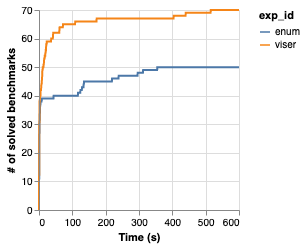

In [4]:
plot_solving_time(["exp_falx_4", "exp_none_4_all"], ["viser", "enum"])

---#sample=4
solved within top 1: 26
solved within top 3: 49
solved within top 5: 57
total: 70
---#sample=8
solved within top 1: 30
solved within top 3: 58
solved within top 5: 63
total: 70
---#sample=6
solved within top 1: 31
solved within top 3: 52
solved within top 5: 57
total: 70
---#sample=16
solved within top 1: 40
solved within top 3: 57
solved within top 5: 62
total: 68


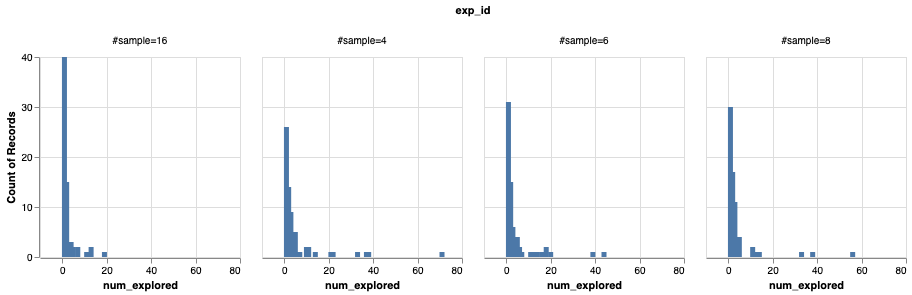

In [5]:
plot_num_candidates(["exp_falx_4", "exp_falx_8", "exp_falx_6", "exp_falx_16"], ["#sample=4", "#sample=8", "#sample=6", "#sample=16"])

---#sample=1
# cases solved within top 5:
['test_21', '050', '025', '058', '001', '011', 'test_7', '042', '032', '012', 'test_15', 'test_10', '023', 'test_1', '052', 'test_6', '035', '010', '006', '054', '051', 'test_14', '056', '024', '017', '053', '020', '033', '031', 'test_8', '047', '030', '029', 'test_2', 'test_11', 'test_13']
solved within top 1: 14
solved within top 3: 29
solved within top 5: 36
total: 66
---#sample=2
# cases solved within top 5:
['test_21', '025', '050', '001', '011', '058', '012', '032', 'test_7', 'test_10', '010', '017', '023', '042', '052', 'test_15', '035', 'test_6', 'test_1', '006', '054', '051', 'test_14', '024', '053', '056', '009', '020', '033', 'test_8', '031', '047', '030', 'test_16', '029', 'test_2', '034', 'test_13', '014', '037', 'test_12', 'test_11', 'test_23']
solved within top 1: 20
solved within top 3: 37
solved within top 5: 43
total: 68
---#sample=3
# cases solved within top 5:
['test_21', '015', '050', '001', '025', '011', '058', '012', '006

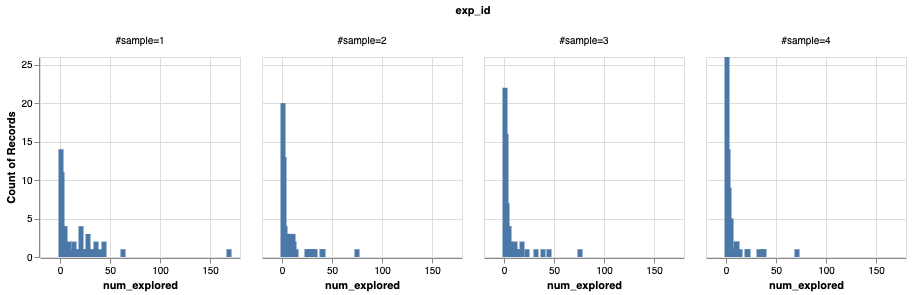

In [17]:
plot_num_candidates(["exp_falx_1", "exp_falx_2", "exp_falx_3", "exp_falx_4"], ["#sample=1", "#sample=2", "#sample=3", "#sample=4"])